In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf

2023-06-15 12:32:26.213753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


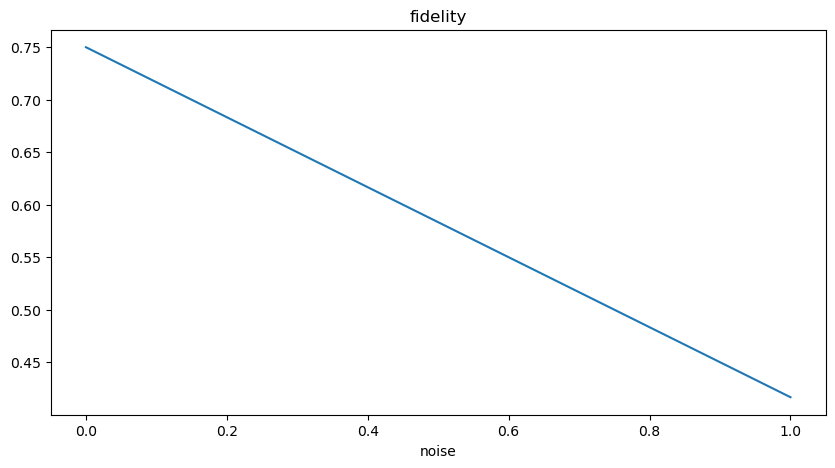

In [2]:
#### it is a test cell 
dev = qml.device('default.mixed', wires=2)
@qml.qnode(dev)
def real1(p):
    #qml.DepolarizingChannel(p,wires=0)
    qml.Rot( 0.0,np.pi/2, np.pi/6,wires=0)
    return qml.density_matrix([0])

@qml.qnode(dev)
def generator(p):
    qml.DepolarizingChannel(p,wires=1)
    qml.RZ(0, wires=1)
    qml.RX(0, wires=1)
    qml.RZ(0, wires=1)
    qml.Rot(0.0, np.pi/2, -np.pi/6,wires=1)
    return qml.density_matrix([1])

#red_r = qml.math.reduced_dm(real1(),indices=[0])
#red_g = qml.math.reduced_dm(generator(),indices=[1])
ps = [0,0.01,0.1,1]
sf = []
for p in ps:
    state_fidelity = qml.math.fidelity(real1(p), generator(p))
    sf.append(state_fidelity)
    
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(ps, sf)
plt.title("fidelity")
plt.xlabel("noise")
plt.show()    

In [3]:
dev = qml.device('default.mixed', wires=2)

In [4]:
def real():
    qml.Rot( 0.0,np.pi/2, np.pi/6,wires=0)
    #qml.DepolarizingChannel(p,wires=0)

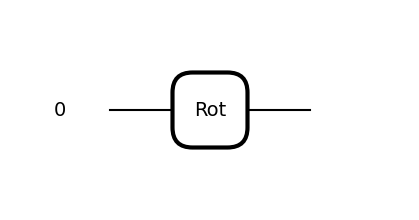

In [5]:
p = 'p'
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(real)()
plt.show()
#print(qml.draw(real)())

In [8]:
def generator(w,**kwargs):
    qml.RZ(np.pi*w[0], wires=1)
    qml.RX(np.pi*w[1], wires=1)
    qml.RZ(np.pi*w[2], wires=1)
    qml.Rot(0.0, np.pi/2, -np.pi/6,wires=1)
    #qml.DepolarizingChannel(p,wires=1)

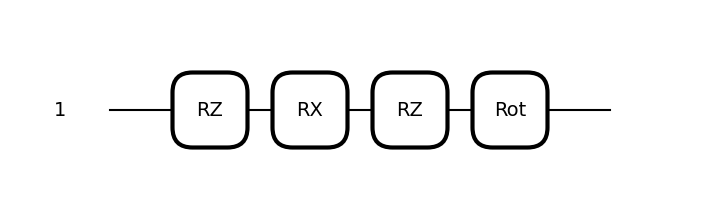

1: ──RZ(3.14)──RX(3.14)──RZ(3.14)──Rot(0.00,1.57,-0.52)─┤  


In [13]:
p = 'p'
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(generator)([ 1,1,1])
plt.show()
print(qml.draw(generator)([ 1,1,1]))

In [42]:
mean=0.01
stdev=0.2
perc = 1
def discriminator(w):
    qml.Hadamard(wires=1)
    #qml.RZ(perc*np.random.normal(mean, stdev), wires=1)    
    qml.CZ(wires=[1, 0])
    #w1[0] = w[0] + 0.01*np.random.rand()
    #w1[1] = w[1] + 0.01*np.random.rand()
    #qml.RZ(w[0] + 0.1*np.random.rand(), wires=0)
    #qml.RZ(w[1] + 0.1*np.random.rand(), wires=1)
    qml.RZ(np.pi*w[0] + perc*np.random.normal(mean, stdev), wires=0)
    qml.RZ(np.pi*w[1] + perc*np.random.normal(mean, stdev), wires=1)    
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    #qml.RZ(perc*np.random.normal(mean, stdev), wires=0) 
    #qml.RZ(perc*np.random.normal(mean, stdev), wires=1)     
    #qml.DepolarizingChannel(p,wires=0)
    #qml.DepolarizingChannel(p,wires=1)

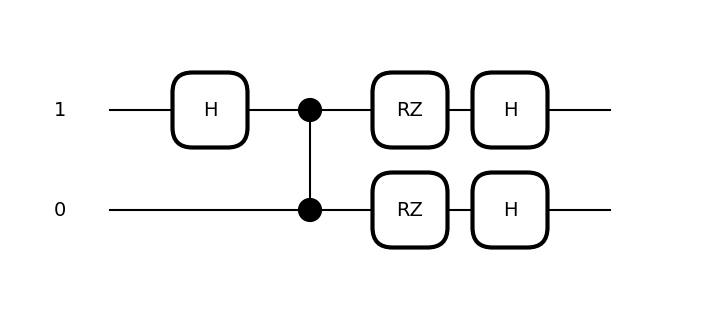

1: ──H─╭●──RZ(3.12)──H─┤  
0: ────╰Z──RZ(3.34)──H─┤  


In [43]:
p = 'p'
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(discriminator)([ 0,0])
plt.show()
print(qml.draw(discriminator)([ 1,1]))

In [44]:
@qml.qnode(dev, interface='tf')
def real_gen_disc_circuit(gen_weights, disc_weights):
    real()
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval((qml.Identity(0)-qml.PauliZ(0))@ (qml.Identity(1)-qml.PauliZ(1)))
#qml.expval(qml.PauliZ(0) @ qml.PauliX(2))


In [45]:
##new
@qml.qnode(dev, interface='tf')
def real_gen_disc_circuit(gen_weights, disc_weights):
    real()
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval((qml.Identity(0)-qml.PauliZ(0))@ (qml.Identity(1)-qml.PauliZ(1)))
#qml.expval(qml.PauliZ(0) @ qml.PauliX(2))

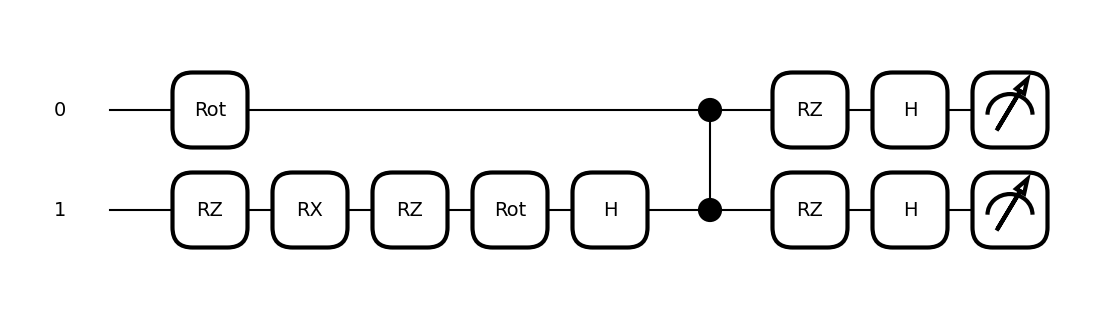

0: ──Rot(0.00,1.57,0.52)──────────────────────────────────────────────╭Z──RZ(3.18)──H─┤ ╭<𝓗>
1: ──RZ(3.14)─────────────RX(3.14)──RZ(3.14)──Rot(0.00,1.57,-0.52)──H─╰●──RZ(3.44)──H─┤ ╰<𝓗>


In [46]:
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(real_gen_disc_circuit)([ 0,0,0,0,0,0,0,0,0],[ 0,0])
plt.show()
print(qml.draw(real_gen_disc_circuit)([ 1,1,1,1,1,1,1,1,1],[ 1,1]))

In [47]:
def prob_discriminated(gen_weights,disc_weights):
    discriminated_output = real_gen_disc_circuit(gen_weights, disc_weights)
    #convert to probability
    prob_discriminated_output = (discriminated_output)/4
    return prob_discriminated_output

In [48]:
def disc_cost(disc_weights):
    cost = 1-prob_discriminated(gen_weights,disc_weights)
    return cost
def gen_cost(gen_weights):
    cost = prob_discriminated(gen_weights,disc_weights)
    return cost

In [49]:
def realf():
    qml.Rot( 0.0,np.pi/2, np.pi/6,wires=0)
@qml.qnode(dev, interface="tf")
def circuit_gs(angles):
    generator(angles)
    return qml.density_matrix([1])
@qml.qnode(dev, interface="tf")
def circuit_rs():
    realf()
    return qml.density_matrix([0])

In [60]:
# perfect swap
p = 0.01
np.random.seed(0)
eps = 1e-2
#init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   #np.random.normal(scale=eps, size=(3,))
#init_gen_weights = np.array([0] + [0] * 2) + \
                  # np.random.normal(scale=eps, size=(3,))    
init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

In [61]:
init_gen_weights
perc*np.random.normal(mean, stdev)

0.3628104691935328

In [62]:
# perfect swap
p = 0.01
np.random.seed(0)
eps = 1e-2
#init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   #np.random.normal(scale=eps, size=(3,))
init_gen_weights = np.array([0] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

# train only generator while discriminator is a perfect swap frozen discriminator
loss_val_d = []
loss_val_g = []
#step_d = []
step_gf = []
sg_f =[]
epochs = 50
a = 1
for i in range(epochs): 
    #opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a)
            step_gf.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            #red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            #red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            #state_fidelity = qml.math.fidelity(red_r, red_g)
            state_fidelity = qml.math.fidelity(circuit_rs(), circuit_gs(var_g))
            sg_f.append(state_fidelity)
            
perfect_swap = sg_f
perfect_step_g = step_gf     

Step 0: cost = 0.0014866618000384454
Step 1: cost = 0.001784154418189049
Step 2: cost = 0.007857567746283128
Step 3: cost = 0.0030151559760372287
Step 4: cost = 0.0184194882911876
Step 5: cost = 0.0014759026658412097
Step 6: cost = 0.01640342934933295
Step 7: cost = 0.025034048656753398
Step 8: cost = 0.00898507742396254
Step 9: cost = 0.006347930866770123
Step 10: cost = 0.02645567411447415
Step 11: cost = 0.005528308887495628
Step 12: cost = 0.012490734772821449
Step 13: cost = 0.0005696384889536665
Step 14: cost = 8.442693083096642e-05
Step 15: cost = 0.009029308508395534
Step 16: cost = 0.003080588907067111
Step 17: cost = 0.00850151044350677
Step 18: cost = 9.388052253069684e-05
Step 19: cost = 0.006956321044893812
Step 20: cost = 0.05820404316219139
Step 21: cost = 0.008658080379641192
Step 22: cost = 0.00036032504651736796
Step 23: cost = 0.005759121332181871
Step 24: cost = 0.01966419902565847
Step 25: cost = 0.006792996914546989
Step 26: cost = 0.026633644182058935
Step 27: co

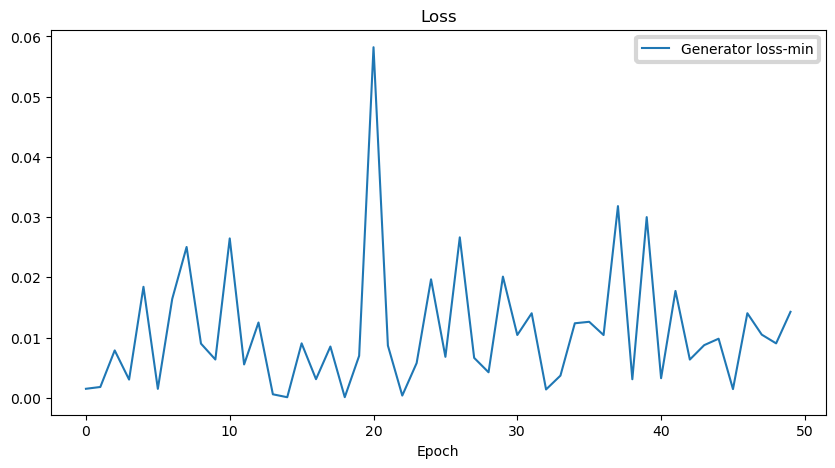

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_gf)), loss_val_g, label="Generator loss-min")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

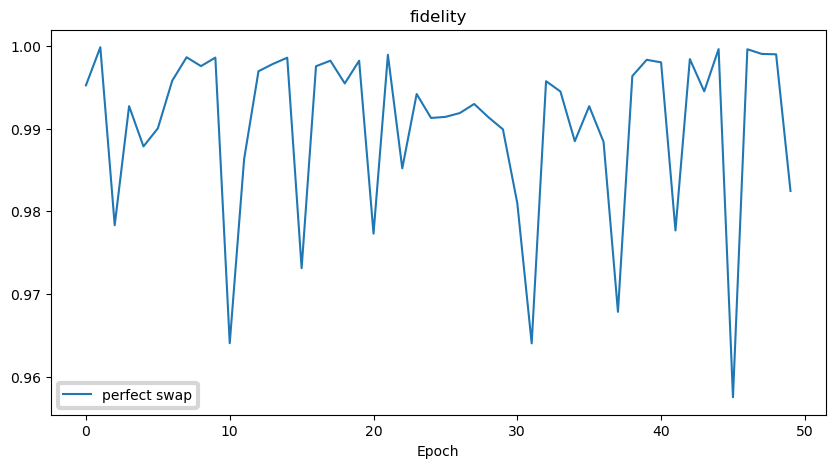

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(perfect_step_g)), perfect_swap, label="perfect swap")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [73]:
#  frozen discriminator + alternative training
#####
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)
#####

loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]

##
#fozen discriminator
epochs1 = 25
a1 = 1
for i in range(epochs1):            
    #opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a1):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a1)
            step_g.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            #red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            #red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            #state_fidelity = qml.math.fidelity(red_r, red_g)
            state_fidelity = qml.math.fidelity(circuit_rs(), circuit_gs(var_g))
            sg.append(state_fidelity)

#alternative training            
epochs2 = 5
a2 = 2
a3 = 2
for i in range(epochs2):
    #opt = tf.keras.optimizers.experimental.Adam(learning_rate=0.01)
    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a2):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step2 = step+a1*epochs1+a2*i+a3*i
            step_d.append(step2)
            print("Step {}: cost = {}".format(step2, loss_val))  
            #red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            #red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            #state_fidelity = qml.math.fidelity(red_r, red_g)
            state_fidelity = qml.math.fidelity(circuit_rs(), circuit_gs(var_g))
            sg.append(state_fidelity) 
            
    #opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a3):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step3 = step+a1*epochs1+a2*(i+1)+a3*(i)
            step_g.append(step3)
            print("Step {}: cost = {}".format(step3, loss_val))
            #red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            #red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            #state_fidelity = qml.math.fidelity(red_r, red_g)
            state_fidelity = qml.math.fidelity(circuit_rs(), circuit_gs(var_g))
            sg.append(state_fidelity)
###
#alternative training            
epochs2 = 5
a2 = 1
a3 = 1
for i in range(epochs2):
    #opt = tf.keras.optimizers.experimental.Adam(learning_rate=0.01)
    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a2):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step2 = step+a1*epochs1+a2*i+a3*i
            step_d.append(step2)
            print("Step {}: cost = {}".format(step2, loss_val))  
            #red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            #red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            #state_fidelity = qml.math.fidelity(red_r, red_g)
            state_fidelity = qml.math.fidelity(circuit_rs(), circuit_gs(var_g))
            sg.append(state_fidelity) 
            
    #opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a3):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step3 = step+a1*epochs1+a2*(i+1)+a3*(i)
            step_g.append(step3)
            print("Step {}: cost = {}".format(step3, loss_val))
            #red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            #red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            #state_fidelity = qml.math.fidelity(red_r, red_g)
            state_fidelity = qml.math.fidelity(circuit_rs(), circuit_gs(var_g))
            sg.append(state_fidelity)

Step 0: cost = 0.0014866618000384454
Step 1: cost = 0.001784154418189049
Step 2: cost = 0.007857567746283128
Step 3: cost = 0.0030151559760372287
Step 4: cost = 0.0184194882911876
Step 5: cost = 0.0014759026658412097
Step 6: cost = 0.01640342934933295
Step 7: cost = 0.025034048656753398
Step 8: cost = 0.00898507742396254
Step 9: cost = 0.006347930866770123
Step 10: cost = 0.02645567411447415
Step 11: cost = 0.005528308887495628
Step 12: cost = 0.012490734772821449
Step 13: cost = 0.0005696384889536665
Step 14: cost = 8.442693083096642e-05
Step 15: cost = 0.009029308508395534
Step 16: cost = 0.003080588907067111
Step 17: cost = 0.00850151044350677
Step 18: cost = 9.388052253069684e-05
Step 19: cost = 0.006956321044893812
Step 20: cost = 0.05820404316219139
Step 21: cost = 0.008658080379641192
Step 22: cost = 0.00036032504651736796
Step 23: cost = 0.005759121332181871
Step 24: cost = 0.01966419902565847
Step 25: cost = 0.9468825380980819
Step 27: cost = 0.025363796890126467
Step 29: cost

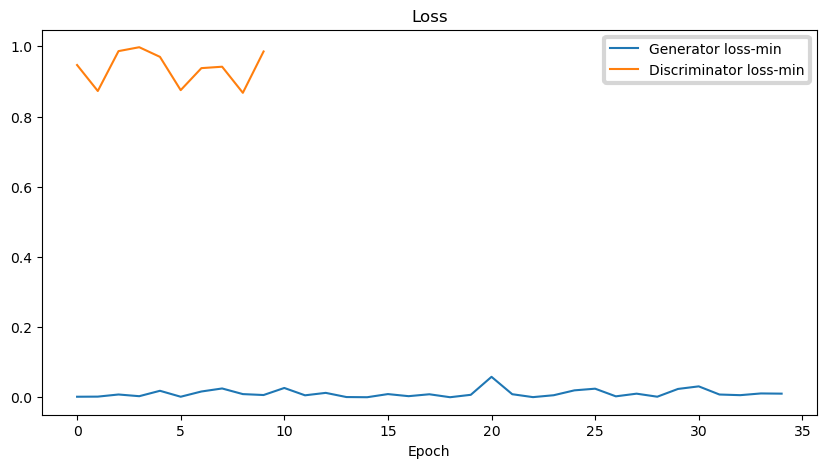

In [70]:
#loss_d = [ 1-x for x in loss_val_d]
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss-min")
plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

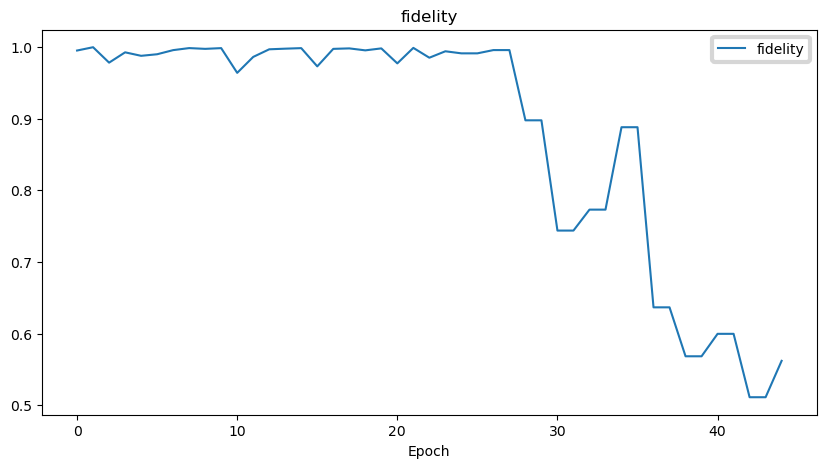

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)+len(step_d)), sg, label="fidelity")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()

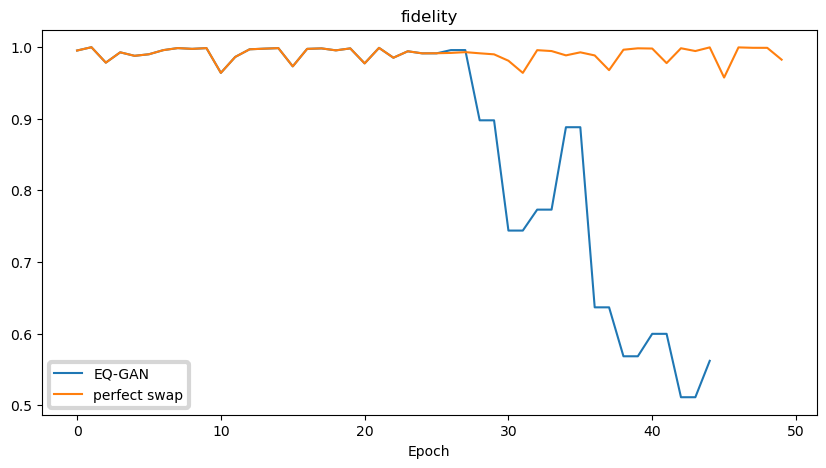

In [72]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g+step_d)), sg, label="EQ-GAN")
plt.plot(range(len(perfect_step_g)), perfect_swap, label="perfect swap")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [59]:
max(sg[:20])

<tf.Tensor: shape=(), dtype=float64, numpy=0.9998310315949293>

In [116]:
max( perfect_swap[:20])

<tf.Tensor: shape=(), dtype=float64, numpy=0.9937012248901821>